<font color = blue><font size = 6> 모델설명 </font></font><br>
이전에 내 모델은 DLinear 기반으로써 시계열 데이터를 seasonal요소와 trend요소를 분해한 이후에 각각의 Linear Layer로 투입 시켰다 이번에는 이 LinearLayer를 LSTM으로 대체해서 DLSTM을 적용해보겠다<br>
이모델은 조기종료를 시켰음을 미리 알리겠다

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [20]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [21]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [22]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':16,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/online_learning_seq2seq']

In [23]:
class Seasonal_Encoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden

In [24]:
class Trend_Encoder(nn.Module):
    def __init__(self,configs):
        super(Trend_Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden


In [25]:
class Seasonal_Decoder(nn.Module):
    def __init__(self,configs):
        super(Seasonal_Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        
        output = self.linear(lstm_out)

        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [26]:
class Trend_Decoder(nn.Module):
    def __init__(self,configs):
        super(Trend_Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        
        output = self.linear(lstm_out)
        
        
        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [27]:
tup= (1,2)
len(tup)

2

In [28]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [29]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [30]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.season_encoder = Seasonal_Encoder(configs)
        self.season_decoder = Seasonal_Decoder(configs)
        self.trend_encoder = Trend_Encoder(configs)
        self.trend_decoder = Trend_Decoder(configs)
        self.device = torch.device('cuda:0')
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        
    def forward(self,x):
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        x = x.permute(0,2,1)
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.permute(0,2,1).to(self.device), trend_init.permute(0,2,1).to(self.device) 
        x = x.permute(0,2,1)
        _,final_season_hidden = self.season_encoder(seasonal_init)
        _,final_trend_hidden = self.trend_encoder(trend_init)
        
        season_output,_ = self.season_decoder(x = seasonal_init[:,-1,:].view(-1,1,1),encoder_hidden = final_season_hidden)
        trend_output,_ = self.trend_decoder(x = trend_init[:,-1,:].view(-1,1,1),encoder_hidden = final_trend_hidden)
        
        output = season_output+trend_output
        
        return output

In [31]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [32]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [33]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [34]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),1e-3)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-03.


In [35]:
torch.manual_seed(42)

In [36]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
#         print(seq)
        out = model(seq)
#         print(out)
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

Adjusting learning rate of group 0 to 9.5000e-04.
smape 46.00687498275098 %
Adjusting learning rate of group 0 to 9.0250e-04.
smape 1.0896109688069877 %
Adjusting learning rate of group 0 to 8.5737e-04.
smape 1.107607645371368 %
Adjusting learning rate of group 0 to 8.1451e-04.
smape 1.1064850155921784 %
Adjusting learning rate of group 0 to 7.7378e-04.
smape 1.097389067280139 %
Adjusting learning rate of group 0 to 7.3509e-04.
smape 1.0858894777395736 %
Adjusting learning rate of group 0 to 6.9834e-04.
smape 1.0732206331711667 %
Adjusting learning rate of group 0 to 6.6342e-04.
smape 1.059633287327495 %
Adjusting learning rate of group 0 to 6.3025e-04.
smape 1.0470485709449657 %
Adjusting learning rate of group 0 to 5.9874e-04.
smape 1.0355186886705556 %
Adjusting learning rate of group 0 to 5.6880e-04.
smape 1.0243900274900086 %
Adjusting learning rate of group 0 to 5.4036e-04.
smape 1.0131347436071183 %
Adjusting learning rate of group 0 to 5.1334e-04.
smape 1.0035639363327418 %
Adj

In [37]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.2609517176169902 %
SMAPE 0.10502333138720132 %
SMAPE 0.0005765110088162828 %
SMAPE 0.000948758358205737 %
SMAPE 0.00984309922534976 %
SMAPE 0.006295793177315544 %
SMAPE 0.003257204107598 %
SMAPE 0.0014512130782762256 %
SMAPE 0.0030545274251281285 %
SMAPE 0.0006075191711971684 %
SMAPE 0.007895708084973307 %
SMAPE 0.015246621298992125 %
SMAPE 0.0020540508860449336 %
SMAPE 0.004383479217636932 %
SMAPE 0.006974171232286608 %
SMAPE 0.024925330770770415 %
SMAPE 0.017153257969781066 %
SMAPE 0.010676269458834042 %
SMAPE 0.007175393805042063 %
SMAPE 0.002114802696667084 %
SMAPE 0.010130575721177593 %
SMAPE 0.004582963003798568 %
SMAPE 0.04704807388475274 %
SMAPE 0.0024077929716384006 %
SMAPE 0.004626259713575109 %
SMAPE 0.01891300922420669 %
SMAPE 0.00903074473359311 %
SMAPE 0.01577494739083818 %
SMAPE 0.0317624010721147 %
SMAPE 0.026612808318873252 %
SMAPE 0.014148655550457077 %
SMAPE 0.0018368799620418483 %
SMAPE 0.0015259344374740635 %
SMAPE 0.0004653421955538306 %
SMAPE 0.0070999722

SMAPE 0.048050889861769974 %
SMAPE 0.0013561601407587887 %
SMAPE 0.0287100063516732 %
SMAPE 0.022805002093605253 %
SMAPE 0.11065264383796602 %
SMAPE 0.058882263820123626 %
SMAPE 0.05109975669211053 %
SMAPE 0.007334364246815993 %
SMAPE 0.011143440664028503 %
SMAPE 0.012753082351736111 %
SMAPE 0.007250587074018711 %
SMAPE 0.009990197288274771 %
SMAPE 0.008980246582723339 %
SMAPE 0.0036982813903776446 %
SMAPE 0.009503616432731121 %
SMAPE 0.007101803994615352 %
SMAPE 0.009347547600548012 %
SMAPE 0.001932849573726969 %
SMAPE 0.0010984624253751463 %
SMAPE 0.0007924995180417227 %
SMAPE 0.003066081140147503 %
SMAPE 0.0009292980085291447 %
SMAPE 0.0024642203497649007 %
SMAPE 0.003912803105919238 %
SMAPE 0.0011568516433584364 %
SMAPE 0.00905189659711425 %
SMAPE 0.002739659379088266 %
SMAPE 0.02007084827999961 %
SMAPE 0.017688561810501824 %
SMAPE 0.006133925131194928 %
SMAPE 0.010034389560985346 %
SMAPE 0.006223202738894429 %
SMAPE 0.005314380851984879 %
SMAPE 0.00491586413255618 %
SMAPE 0.056094

SMAPE 0.011667773559082661 %
SMAPE 0.013181730093620558 %
SMAPE 0.0052448517179470855 %
SMAPE 0.007308695688578837 %
SMAPE 0.001020877872640824 %
SMAPE 0.007680161175755984 %
SMAPE 0.026836309672830797 %
SMAPE 0.0006691274977868034 %
SMAPE 0.032296688503606674 %
SMAPE 0.004366009166517415 %
SMAPE 0.0017088456504126273 %
SMAPE 0.02649823710794408 %
SMAPE 0.005937367925241688 %
SMAPE 0.0805730409338139 %
SMAPE 0.02311148866243684 %
SMAPE 0.013036205417947146 %
SMAPE 0.0026305148202752093 %
SMAPE 0.0020696607797887623 %
SMAPE 0.02402259882586577 %
SMAPE 0.0017145019083386615 %
SMAPE 0.002190639262892091 %
SMAPE 0.0029339059502575537 %
SMAPE 0.000848146775240366 %
SMAPE 0.007005071091384707 %
SMAPE 0.011022093449611248 %
SMAPE 0.0036183622510819195 %
SMAPE 0.003483237440924825 %
SMAPE 0.0010534007642775123 %
SMAPE 0.0019221516198228983 %
SMAPE 0.04520036329950017 %
SMAPE 0.0005961512637639999 %
SMAPE 0.0031111696801175985 %
SMAPE 0.0025403407737627504 %
SMAPE 0.015320745053408304 %
SMAPE 0

SMAPE 0.009870721355397905 %
SMAPE 0.062017691190703765 %
SMAPE 0.02392563001455983 %
SMAPE 0.01236334300101305 %
SMAPE 0.0018306750155403508 %
SMAPE 0.000351334872419784 %
SMAPE 0.10933822870720178 %
SMAPE 0.029922938545496436 %
SMAPE 0.011422737625096602 %
SMAPE 0.00027884397508159964 %
SMAPE 0.005013658597412984 %
SMAPE 0.017627539207182963 %
SMAPE 0.01837336540857848 %
SMAPE 0.010528974025575621 %
SMAPE 0.0018635309609180695 %
SMAPE 5.988295895065221e-05 %
SMAPE 0.029079842304213344 %
SMAPE 0.0055578976953967185 %
SMAPE 0.012161355299951992 %
SMAPE 0.007491348619552696 %
SMAPE 0.0007583344644785939 %
SMAPE 0.010725665219240454 %
SMAPE 0.018618347357971743 %
SMAPE 0.0006007360088844393 %
SMAPE 0.024333352964447386 %
SMAPE 0.008648879950499122 %
SMAPE 0.0020868525141395367 %
SMAPE 0.0018906685373281107 %
SMAPE 0.00020438025975977323 %
SMAPE 0.005591720018884416 %
SMAPE 0.00874846404271068 %
SMAPE 0.014699684968945801 %
SMAPE 0.00450906849513899 %
SMAPE 0.005468945846217821 %
SMAPE 0.

SMAPE 0.0020931302233293536 %
SMAPE 0.008770242100425207 %
SMAPE 0.00016302634384146586 %
SMAPE 0.0029321458058788608 %
SMAPE 0.017885065195940797 %
SMAPE 0.020221403119194292 %
SMAPE 0.001518371551426867 %
SMAPE 0.0077792629251689505 %
SMAPE 0.0011298151177641103 %
SMAPE 0.003230411309402825 %
SMAPE 0.006617870640916123 %
SMAPE 0.010945027997792067 %
SMAPE 0.0054628680239261485 %
SMAPE 0.055680029054201434 %
SMAPE 0.004100951422572052 %
SMAPE 0.0019167859093158768 %
SMAPE 0.003898617340603039 %
SMAPE 0.02122622027054888 %
SMAPE 0.013380860379413662 %
SMAPE 0.0007399125037750309 %
SMAPE 0.02508670334151475 %
SMAPE 0.018875400998695113 %
SMAPE 0.00042636719813060614 %
SMAPE 0.0028242291288052 %
SMAPE 0.0006621763831660132 %
SMAPE 0.0011768415368251794 %
SMAPE 0.014062924984784786 %
SMAPE 0.010031730821282281 %
SMAPE 0.020858941469043657 %
SMAPE 0.0004283352765952486 %
SMAPE 0.003935475658380483 %
SMAPE 0.0058200777125421155 %
SMAPE 0.007660856084925172 %
SMAPE 0.0037756727117539413 %
SM

SMAPE 0.009094396931871529 %
SMAPE 0.0016736125863729967 %
SMAPE 0.00018465226523289857 %
SMAPE 0.002170134518962641 %
SMAPE 0.0029779047264923975 %
SMAPE 0.0033405144879594673 %
SMAPE 0.009675524095882793 %
SMAPE 0.04223380890152839 %
SMAPE 0.013624575720598388 %
SMAPE 0.0024879924572900336 %
SMAPE 0.0029545356498630326 %
SMAPE 0.016314810048982054 %
SMAPE 0.021058157122979537 %
SMAPE 0.004367858451217899 %
SMAPE 0.0033849060733359693 %
SMAPE 0.029966492723417563 %
SMAPE 0.01993097247470388 %
SMAPE 0.0010292562160358898 %
SMAPE 0.025911096712661674 %
SMAPE 0.04189248679324464 %
SMAPE 0.0098521630547026 %
SMAPE 0.016104316658093865 %
SMAPE 0.0013960710274005805 %
SMAPE 0.0007632895883133983 %
SMAPE 0.00040469349252703063 %
SMAPE 0.002699095444882005 %
SMAPE 0.001580299804103902 %
SMAPE 0.0021060205772513996 %
SMAPE 0.0045056953337478944 %
SMAPE 0.0016626596753042122 %
SMAPE 0.02242061284177055 %
SMAPE 0.025923550746085766 %
SMAPE 0.005528322682295084 %
SMAPE 0.00037593625992826674 %
SM

SMAPE 0.013848389758379652 %
SMAPE 0.01090348602690483 %
SMAPE 0.0028592939211762314 %
SMAPE 0.008874584457686296 %
SMAPE 0.006860333257947105 %
SMAPE 0.00020555790955967265 %
SMAPE 0.0005901822222540432 %
SMAPE 0.011905473858156768 %
SMAPE 0.004038605623051694 %
SMAPE 0.002702763455317836 %
SMAPE 0.002034921074361762 %
SMAPE 0.0014150229030676087 %
SMAPE 0.009814465824568686 %
SMAPE 0.004007752350652538 %
SMAPE 0.009858586018289373 %
SMAPE 0.014498491585641204 %
SMAPE 0.004122728189003055 %
SMAPE 0.024075013958395175 %
SMAPE 0.00041051168319938824 %
SMAPE 0.00528433743279777 %
SMAPE 0.0042888779010397116 %
SMAPE 0.0011109037776009245 %
SMAPE 0.0037957937415882275 %
SMAPE 0.005510885567488799 %
SMAPE 0.0008073770803775915 %
SMAPE 0.012731506093217606 %
SMAPE 0.01540022468967095 %
SMAPE 0.001706237885940709 %
SMAPE 0.011311209671376332 %
SMAPE 0.006944950621672773 %
SMAPE 0.00012736562581494582 %
SMAPE 0.008480467178245021 %
SMAPE 0.003268919740762044 %
SMAPE 0.0015481973279278805 %
SMA

SMAPE 0.0220280788406626 %
SMAPE 0.01094131118304631 %
SMAPE 0.0009824109751974675 %
SMAPE 0.004947385762250178 %
SMAPE 0.0011440526062926892 %
SMAPE 0.0008261984671378286 %
SMAPE 0.005148888600459145 %
SMAPE 0.000696177679401444 %
SMAPE 0.02457165817165219 %
SMAPE 0.008197258912673533 %
SMAPE 0.001982263447885657 %
SMAPE 0.04551590131222838 %
SMAPE 0.05461558889464868 %
SMAPE 0.0030754032811444176 %
SMAPE 0.0042101308875146515 %
SMAPE 0.004039122419328578 %
SMAPE 0.002223427159421476 %
SMAPE 0.0017613635692157459 %
SMAPE 0.04046561524842218 %
SMAPE 0.011871408967266461 %
SMAPE 0.0014311387254224428 %
SMAPE 0.004968411443144305 %
SMAPE 0.007726016809868953 %
SMAPE 0.003162764436119403 %
SMAPE 0.011093464347055715 %
SMAPE 0.003467815236561478 %
SMAPE 0.0008703619824785847 %
SMAPE 0.01314885866440818 %
SMAPE 0.006231172620793757 %
SMAPE 0.03323264633809231 %
SMAPE 0.052807334581530085 %
SMAPE 0.02267731917402216 %
SMAPE 0.0010117267883416048 %
SMAPE 0.008078577153938227 %
SMAPE 0.0033562

SMAPE 0.017220825823983432 %
SMAPE 0.007270949913930735 %
SMAPE 0.011893308316132334 %
SMAPE 0.002384381047846773 %
SMAPE 0.010024986401617753 %
SMAPE 0.0007280425260205448 %
SMAPE 0.01813240862981047 %
SMAPE 0.003361442921118396 %
SMAPE 0.0006433936781462535 %
SMAPE 0.0019414642109083502 %
SMAPE 0.010025508221900736 %
SMAPE 0.0013727590663989986 %
SMAPE 0.00024305797222723413 %
SMAPE 0.00424709556192937 %
SMAPE 0.001439687275393453 %
SMAPE 0.017960929146511262 %
SMAPE 0.01603465098730794 %
SMAPE 0.009971421180964057 %
SMAPE 0.01156282346786952 %
SMAPE 0.025605322811884434 %
SMAPE 0.0030077712788170174 %
SMAPE 0.0057086629797709065 %
SMAPE 0.0015794745765802531 %
SMAPE 0.003728895209391681 %
SMAPE 0.016845872597748723 %
SMAPE 0.0003878326322208636 %
SMAPE 0.0011595332304352723 %
SMAPE 0.007974519287557769 %
SMAPE 0.022910343977343928 %
SMAPE 0.0008127225074616717 %
SMAPE 0.018210633252493835 %
SMAPE 0.014903491760321685 %
SMAPE 0.004704881515593229 %
SMAPE 0.010991732453035752 %
SMAPE 

SMAPE 0.0015123914301540253 %
SMAPE 0.0007040941978999626 %
SMAPE 0.0005183828357786524 %
SMAPE 0.007414116010387772 %
SMAPE 0.022389918719397883 %
SMAPE 0.023207448276508558 %
SMAPE 0.012487826663999614 %
SMAPE 0.008711349020188663 %
SMAPE 0.020771752942636112 %
SMAPE 0.004723493092399167 %
SMAPE 0.01625729150853772 %
SMAPE 0.002385075629881328 %
SMAPE 0.00544143699460875 %
SMAPE 0.03271000870529406 %
SMAPE 0.001206404860269572 %
SMAPE 0.0021363059074559487 %
SMAPE 0.007756442632540939 %
SMAPE 0.021671541755608814 %
SMAPE 0.002169611407254024 %
SMAPE 0.006249653571892111 %
SMAPE 0.0012381948058504122 %
SMAPE 0.007637098779639473 %
SMAPE 0.03562012725240038 %
SMAPE 0.013696722956979102 %
SMAPE 0.015141840244297098 %
SMAPE 0.0017040338743541381 %
SMAPE 0.003542349404760614 %
SMAPE 0.0009446486773896367 %
SMAPE 0.0067106814453481425 %
SMAPE 0.010941963273708666 %
SMAPE 0.008016388315098766 %
SMAPE 0.000505173345629828 %
SMAPE 0.007903301766930326 %
SMAPE 0.0028279756124618416 %
SMAPE 0.0

SMAPE 0.003351666286526722 %
SMAPE 0.001961728354061165 %
SMAPE 0.0019839054234722653 %
SMAPE 0.006415082369585433 %
SMAPE 0.010930279089457429 %
SMAPE 0.0038704363170154465 %
SMAPE 0.001365662560004921 %
SMAPE 0.0007240691613930039 %
SMAPE 0.018523427921991242 %
SMAPE 0.0004057969789457161 %
SMAPE 0.008685020000029908 %
SMAPE 0.013756715573435942 %
SMAPE 0.00017406460796109968 %
SMAPE 0.00758541819193681 %
SMAPE 0.0021612188603938876 %
SMAPE 0.0022102007283137937 %
SMAPE 0.009119702090018222 %
SMAPE 0.0067482212925256135 %
SMAPE 0.0031087658202864077 %
SMAPE 0.0012777011068152433 %
SMAPE 0.006484830966059007 %
SMAPE 0.005013040946465708 %
SMAPE 0.012636241446841723 %
SMAPE 0.001449890397168474 %
SMAPE 0.0001892569846759784 %
SMAPE 0.002259240509587812 %
SMAPE 0.01551282327935155 %
SMAPE 0.005822592701974827 %
SMAPE 8.819770820438862 %
SMAPE 17.70463728904724 %
SMAPE 25.325032591819763 %
SMAPE 8.846258454024792 %
SMAPE 7.665002703666687 %
SMAPE 6.991499729454517 %
SMAPE 1.5595154846087

SMAPE 0.0019702784866382217 %
SMAPE 0.003916730666531976 %
SMAPE 0.0017856894789360922 %
SMAPE 0.0025240083288196047 %
SMAPE 0.013138439271386915 %
SMAPE 0.014233985787676318 %
SMAPE 0.014418831711736857 %
SMAPE 0.0003404529879560414 %
SMAPE 0.001096545235782287 %
SMAPE 0.019391564197761113 %
SMAPE 0.01578471396783243 %
SMAPE 0.016676117440454163 %
SMAPE 0.0039856308108028315 %
SMAPE 0.002172620306659212 %
SMAPE 0.025456527045449207 %
SMAPE 0.003854118590574273 %
SMAPE 0.015590598980708137 %
SMAPE 0.024911478866883385 %
SMAPE 0.0016894175930488586 %
SMAPE 0.01562857149547625 %
SMAPE 0.0099312738703361 %
SMAPE 0.0005462137063858563 %
SMAPE 0.009417676977534484 %
SMAPE 0.008778707304145428 %
SMAPE 0.005033483060415733 %
SMAPE 0.0040636390306758585 %
SMAPE 0.0010334187483351798 %
SMAPE 0.02682113249582585 %
SMAPE 0.0019150085534107575 %
SMAPE 0.02701167039535335 %
SMAPE 0.0011511484313615483 %
SMAPE 0.0038937264978216035 %
SMAPE 0.0029484272008488688 %
SMAPE 0.00459065001872716 %
SMAPE 0.

SMAPE 0.027245961011715284 %
SMAPE 0.0055441237370175145 %
SMAPE 0.01074044926821216 %
SMAPE 0.0010272013667105284 %
SMAPE 0.01202018354183565 %
SMAPE 0.02018404160904197 %
SMAPE 0.00999977620978143 %
SMAPE 0.006385531893513985 %
SMAPE 0.02163147955903355 %
SMAPE 0.003507673883859752 %
SMAPE 0.0028440813669305953 %
SMAPE 0.00955421572550108 %
SMAPE 0.021062547136864396 %
SMAPE 0.003404625340323264 %
SMAPE 0.023118188635464776 %
SMAPE 0.0024528229821783043 %
SMAPE 0.0015313362287301402 %
SMAPE 0.005519896688596759 %
SMAPE 0.0012219031617775045 %
SMAPE 0.013317961108441523 %
SMAPE 0.007784135735832366 %
SMAPE 0.0006782318924649644 %
SMAPE 0.006286525837808199 %
SMAPE 0.028509709942525774 %
SMAPE 0.008153588761558694 %
SMAPE 0.010344331930042472 %
SMAPE 0.02346492639247799 %
SMAPE 0.0012584378641520289 %
SMAPE 0.012748859712047533 %
SMAPE 0.013109699180517962 %
SMAPE 0.004977385541678814 %
SMAPE 0.029439276908760803 %
SMAPE 0.002766607629837381 %
SMAPE 0.00119016450472742 %
SMAPE 0.023778

SMAPE 0.007563424800842711 %
SMAPE 0.00885379553621135 %
SMAPE 0.01186055404622266 %
SMAPE 0.004974273325558443 %
SMAPE 0.00893414841235085 %
SMAPE 0.01810115461182704 %
SMAPE 0.07032567357236985 %
SMAPE 0.007774409302555795 %
SMAPE 0.03429509294207378 %
SMAPE 0.004798676492242748 %
SMAPE 0.017629876205091932 %
SMAPE 0.005770052198244002 %
SMAPE 0.007107019240088164 %
SMAPE 0.02741016225786552 %
SMAPE 0.001162172817473106 %
SMAPE 0.016394983768321936 %
SMAPE 0.015647847692861205 %
SMAPE 0.034834198827581986 %
SMAPE 0.011290929345577183 %
SMAPE 0.005172817638907645 %
SMAPE 0.003888191476399072 %
SMAPE 0.0008881751454197228 %
SMAPE 0.06777043976762798 %
SMAPE 0.0388987454243761 %
SMAPE 0.0009992333228723282 %
SMAPE 0.009965208861110852 %
SMAPE 0.021140480766462133 %
SMAPE 0.0017230002622312668 %
SMAPE 0.01541021858041347 %
SMAPE 0.014282920006579049 %
SMAPE 0.02503525583315991 %
SMAPE 0.004097909903521213 %
SMAPE 0.002594875709924338 %
SMAPE 0.008205121385977066 %
SMAPE 0.010363416950347

SMAPE 0.014011342758749379 %
SMAPE 0.012656513166938053 %
SMAPE 0.0017078658829632332 %
SMAPE 0.022530331264796644 %
SMAPE 0.0011132047266499967 %
SMAPE 0.005447550117537503 %
SMAPE 0.0001861581135571555 %
SMAPE 0.019181840837262598 %
SMAPE 0.009152503192851213 %
SMAPE 0.012390612222276332 %
SMAPE 0.05879358366655651 %
SMAPE 0.07858758268412203 %
SMAPE 0.0014849045112157455 %
SMAPE 0.0004195360588425956 %
SMAPE 0.0019802927695806716 %
SMAPE 0.0042785279433914525 %
SMAPE 0.004497987923457458 %
SMAPE 0.010337902554027778 %
SMAPE 0.0009662584075940116 %
SMAPE 0.0009527503741324493 %
SMAPE 0.013937055343120617 %
SMAPE 0.005671057871595053 %
SMAPE 0.0057034316926376505 %
SMAPE 0.0021478870022235697 %
SMAPE 0.0293789238919544 %
SMAPE 0.03964299072913491 %
SMAPE 0.06660867700702511 %
SMAPE 0.001449298465061588 %
SMAPE 0.030439546010484264 %
SMAPE 0.002545197956457912 %
SMAPE 0.0014786227510654726 %
SMAPE 0.027480100218838285 %
SMAPE 0.017294219889961937 %
SMAPE 0.0031897629419219697 %
SMAPE 0

SMAPE 0.008188409518353978 %
SMAPE 0.03973517183862896 %
SMAPE 0.003625066816525191 %
SMAPE 0.0019978982197841333 %
SMAPE 0.003527607359757212 %
SMAPE 0.021470540671032268 %
SMAPE 0.022406345041247278 %
SMAPE 0.008577271131741782 %
SMAPE 0.001348882824146358 %
SMAPE 0.005845959662906353 %
SMAPE 0.0008513642877048255 %
SMAPE 0.0055253004239403936 %
SMAPE 0.00024023298719555441 %
SMAPE 0.006706266811988826 %
SMAPE 0.0011096875895049152 %
SMAPE 0.001328839425461581 %
SMAPE 0.0052640618516903714 %
SMAPE 0.003450468992191702 %
SMAPE 0.0013817041850856526 %
SMAPE 0.002258009732074129 %
SMAPE 0.0014935277052643414 %
SMAPE 0.013025499044147182 %
SMAPE 0.005415768783421981 %
SMAPE 0.019925844909948864 %
SMAPE 0.013681179730212989 %
SMAPE 0.0018199643762528694 %
SMAPE 0.009634216885302749 %
SMAPE 0.007289936600876956 %
SMAPE 0.03990701738325697 %
SMAPE 0.06853440991835669 %
SMAPE 0.009233842686683147 %
SMAPE 0.000728068078871047 %
SMAPE 0.01741288095807647 %
SMAPE 0.008699082774427325 %
SMAPE 0.

SMAPE 0.02376248314524787 %
SMAPE 0.0508859399657311 %
SMAPE 0.023331558054564994 %
SMAPE 0.01762923272566752 %
SMAPE 0.026303788506908177 %
SMAPE 0.010740033285856043 %
SMAPE 0.03129371644729417 %
SMAPE 0.011083037130198647 %
SMAPE 0.006236777243060488 %
SMAPE 0.010803100051873571 %
SMAPE 0.00599889447805424 %
SMAPE 0.004213331219006022 %
SMAPE 0.0021099939537805312 %
SMAPE 0.017906726179234056 %
SMAPE 0.006084334622755705 %
SMAPE 0.0032322335933585578 %
SMAPE 0.010736530329722882 %
SMAPE 0.002126086199950805 %
SMAPE 0.003250273976732388 %
SMAPE 0.004512601693392071 %
SMAPE 0.0059871092157379735 %
SMAPE 0.00405855961604118 %
SMAPE 0.0010237125157246396 %
SMAPE 0.0004799345616532947 %
SMAPE 0.0010721354733647104 %
SMAPE 0.00044779867881317165 %
SMAPE 0.0016756057287921067 %
SMAPE 0.0045649694797660345 %
SMAPE 0.000580742472564566 %
SMAPE 0.004640786222651627 %
SMAPE 0.0001742692488164721 %
SMAPE 0.0005725915801519932 %
SMAPE 0.0020590557808475296 %
SMAPE 0.003154904460231478 %
SMAPE 0.

SMAPE 0.05597387218574568 %
SMAPE 0.1354820295182435 %
SMAPE 0.2749916383763775 %
SMAPE 0.010075585587642877 %
SMAPE 0.025304100603797508 %
SMAPE 0.008839201217995196 %
SMAPE 0.04104609338089915 %
SMAPE 0.0034896311641432476 %
SMAPE 0.03869121163737077 %
SMAPE 0.0013225461358885582 %
SMAPE 0.0028038670286036904 %
SMAPE 0.019029371544860396 %
SMAPE 0.13861810909656924 %
SMAPE 0.007520993179028324 %
SMAPE 0.07791014263159468 %
SMAPE 0.00790776727149023 %
SMAPE 0.004000179154232342 %
SMAPE 0.0017990641988205882 %
SMAPE 0.08131406869767943 %
SMAPE 0.07880423507592127 %
SMAPE 0.0019432288493135275 %
SMAPE 0.0008265164317293737 %
SMAPE 0.006545387087214749 %
SMAPE 0.024408969689545756 %
SMAPE 0.006973968963222887 %
SMAPE 0.017570925118441494 %
SMAPE 0.008900223379001204 %
SMAPE 0.018857659479976974 %
SMAPE 0.008182571727516574 %
SMAPE 0.006974940201253333 %
SMAPE 0.05593483096330942 %
SMAPE 0.0006210489562263888 %
SMAPE 0.020402304881713462 %
SMAPE 0.029085575632336713 %
SMAPE 0.000781049839

SMAPE 1.1203845366835594 %
SMAPE 0.4290259811095893 %
SMAPE 0.010874106305465148 %
SMAPE 0.6433652844280005 %
SMAPE 0.29401766671799123 %
SMAPE 0.23880148341413587 %
SMAPE 0.275722861639224 %
SMAPE 0.5742028062231839 %
SMAPE 0.09597403794896309 %
SMAPE 0.007722249504887201 %
SMAPE 0.27898939047008753 %
SMAPE 0.06130869212665857 %
SMAPE 0.35043241176754236 %
SMAPE 0.34368337667547166 %
SMAPE 0.028383649485704154 %
SMAPE 0.0314124263381359 %
SMAPE 0.011324681832746819 %
SMAPE 0.10778350889813738 %
SMAPE 0.43036905280314386 %
SMAPE 0.22602735960390422 %
SMAPE 0.23823278467170894 %
SMAPE 0.005949112351984809 %
SMAPE 0.0094555889084873 %
SMAPE 0.3331650362815708 %
SMAPE 0.11948677182249412 %
SMAPE 0.2075451101991348 %
SMAPE 0.0077955734312809 %
SMAPE 0.19380406907293946 %
SMAPE 0.02745479448939392 %
SMAPE 0.4386480459943414 %
SMAPE 0.0034802071968442756 %
SMAPE 0.16064658050891012 %
SMAPE 0.03585151660814745 %
SMAPE 0.25630117557011545 %
SMAPE 0.3263409873470664 %
SMAPE 0.036783683152293634

KeyboardInterrupt: 

In [38]:
len(pred_list)

5365

In [39]:
target=list(target.values.reshape(-1))

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')

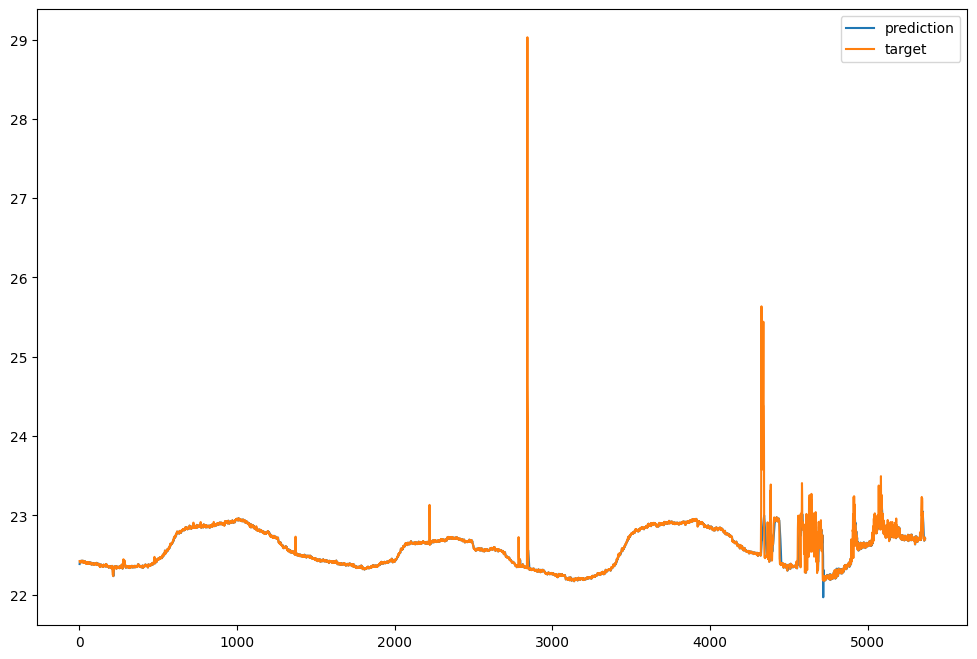

In [42]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,5366),pred_list,label='prediction')
axes.plot(np.arange(1,5366),target[:5365],label='target')
axes.legend()

<font color = blue><font size = 6> 조기종료 </font></font><br>
&downarrow; 모델이 기존의 seq2seq online learning 처럼 sliding된 경향을 강하게 보이기 때문에 조기종료 시켰다

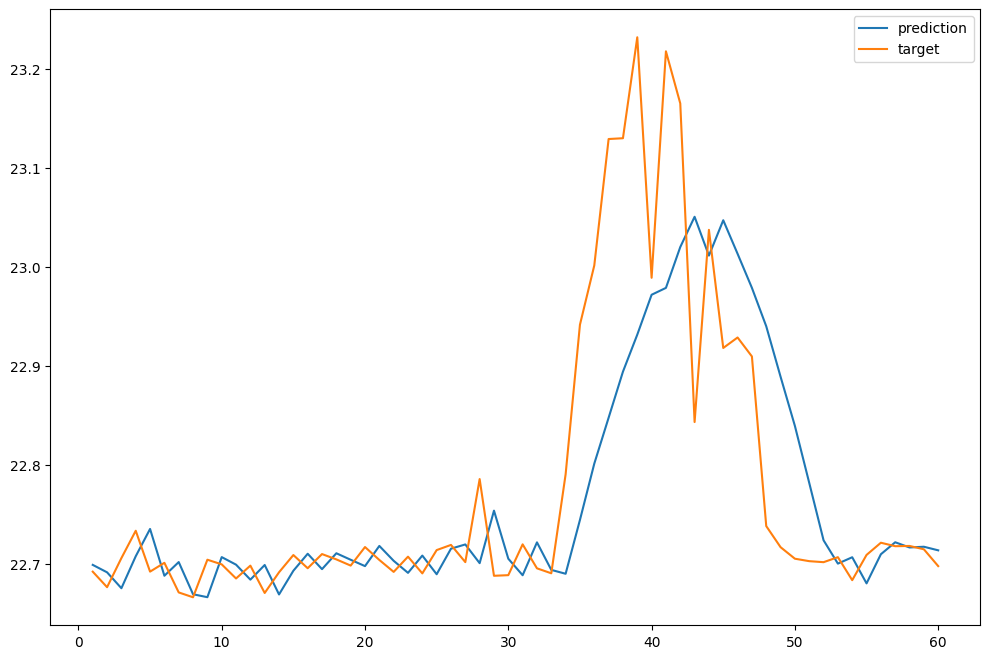

In [43]:
target = target[:5365]
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [44]:
np.mean(time_list)

1.0450118080434239